# Dispatch Testing

Brendan Smithyman | March 2015

In [1]:
import numpy as np
import networkx
from zephyr.Dispatcher import SeisFDFDDispatcher
from IPython.parallel import Reference
from pymatsolver import MumpsSolver
import SimPEG
import scipy.sparse

## Plotting configuration

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
matplotlib.rcParams['savefig.dpi'] = 300 # Change this to adjust figure size

# Plotting options
font = {
    'family': 'Bitstream Vera Sans',
    'weight': 'normal',
    'size': 8,
}

matplotlib.rc('font', **font)

## System / modelling configuration

In [3]:
cellSize    = 1             # m
freqs       = [2e2]         # Hz
density     = 2700          # units of density
Q           = 500           # can be inf
nx          = 164           # count
nz          = 264           # count
freeSurf    = [False, False, False, False] # t r b l
dims        = (nx,nz)       # tuple
nPML        = 32
rho         = np.fliplr(np.ones(dims) * density)
nfreq       = len(freqs)    # number of frequencies
nky         = 1             # number of y-directional plane-wave components
nsp         = nfreq * nky   # total number of 2D subproblems

velocity    = 2500          # m/s
vanom       = 0             # m/s
cPert       = np.zeros(dims)
cPert[(nx/2)-20:(nx/2)+20,(nz/2)-20:(nz/2)+20] = vanom
c           = np.fliplr(np.ones(dims) * velocity)
cFlat       = c
c          += np.fliplr(cPert)
cTrue       = c

srcs        = np.array([np.ones(101)*32, np.zeros(101), np.linspace(32, 232, 101)]).T
recs        = np.array([np.ones(101)*132, np.zeros(101), np.linspace(32, 232, 101)]).T
nsrc        = len(srcs)
nrec        = len(recs)
recmode     = 'fixed'

geom        = {
    'src':  srcs,
    'rec':  recs,
    'mode': 'fixed',
}

cache       = False
cacheDir    = '.'

parFac = 2
chunksPerWorker = 0.5       # NB: parFac * chunksPerWorker = number of source array subsets
ensembleClear = False

profile = 'mpi'

# Base configuration for all subproblems
systemConfig = {
    'dx':   cellSize,       # m
    'dz':   cellSize,       # m
    'c':        c.T,        # m/s
    'rho':      rho.T,      # density
    'Q':        Q,          # can be inf
    'nx':       nx,         # count
    'nz':       nz,         # count
    'freeSurf': freeSurf,   # t r b l
    'nPML':     nPML,
    'geom':     geom,
    'cache':    cache,
    'cacheDir': cacheDir,
    'freqs':    freqs,
    'nky':      nky,
    'parFac':   parFac,
    'chunksPerWorker':  chunksPerWorker,
    'profile':  profile,
    'ensembleClear':    ensembleClear,
#     'MPI': False,
#    'Solver':   Reference('SimPEG.SolverWrapD(scipy.sparse.linalg.splu)'),#Solver,
}

In [4]:
%%time
sp = SeisFDFDDispatcher(systemConfig)
survey, problem = sp.spawnInterfaces()
txs = survey.genTx()
sp.txs = txs

CPU times: user 427 ms, sys: 54.5 ms, total: 482 ms
Wall time: 1.47 s


In [5]:
%%time
d = survey.projectFields()

CPU times: user 1.84 s, sys: 409 ms, total: 2.25 s
Wall time: 24.7 s


In [6]:
%%time
uF = problem.fields()

CPU times: user 122 ms, sys: 123 ms, total: 245 ms
Wall time: 641 ms


In [7]:
%%time
sp.backprop()
uB = sp.uB

CPU times: user 1.55 s, sys: 394 ms, total: 1.95 s
Wall time: 20.2 s


In [10]:
%%time
g = sp.g

CPU times: user 133 ms, sys: 83.8 ms, total: 217 ms
Wall time: 788 ms


In [11]:
g

{0: array([[-0.10592124-0.05662902j, -0.16821099-0.27518328j,
          0.06490934-0.61897266j, ...,  0.03642076-0.19020941j,
          0.06372858-0.08418216j,  0.04019918-0.02062047j],
        [-0.12778750+0.02975242j, -0.32772621-0.08222979j,
         -0.39231684-0.48052056j, ...,  0.15823541-0.05369596j,
          0.09643371+0.02057874j,  0.03682888+0.02729488j],
        [-0.08395939+0.11346205j, -0.31095575+0.17827345j,
         -0.63011290-0.05355491j, ...,  0.10276804+0.09900979j,
          0.01951560+0.09337061j, -0.00808101+0.04699434j],
        ..., 
        [ 0.07671274-0.14389055j,  0.24887830-0.33789564j,
          0.54973875-0.43289584j, ...,  0.27922654-0.1050384j ,
          0.11983430-0.15581396j,  0.03430332-0.07357122j],
        [-0.07629686-0.13951238j, -0.14212156-0.38610006j,
         -0.05677556-0.68710612j, ...,  0.34383062-0.03274329j,
          0.19027902-0.11098201j,  0.06574854-0.05283083j],
        [-0.15458281-0.01189563j, -0.39282518-0.0911448j ,
         

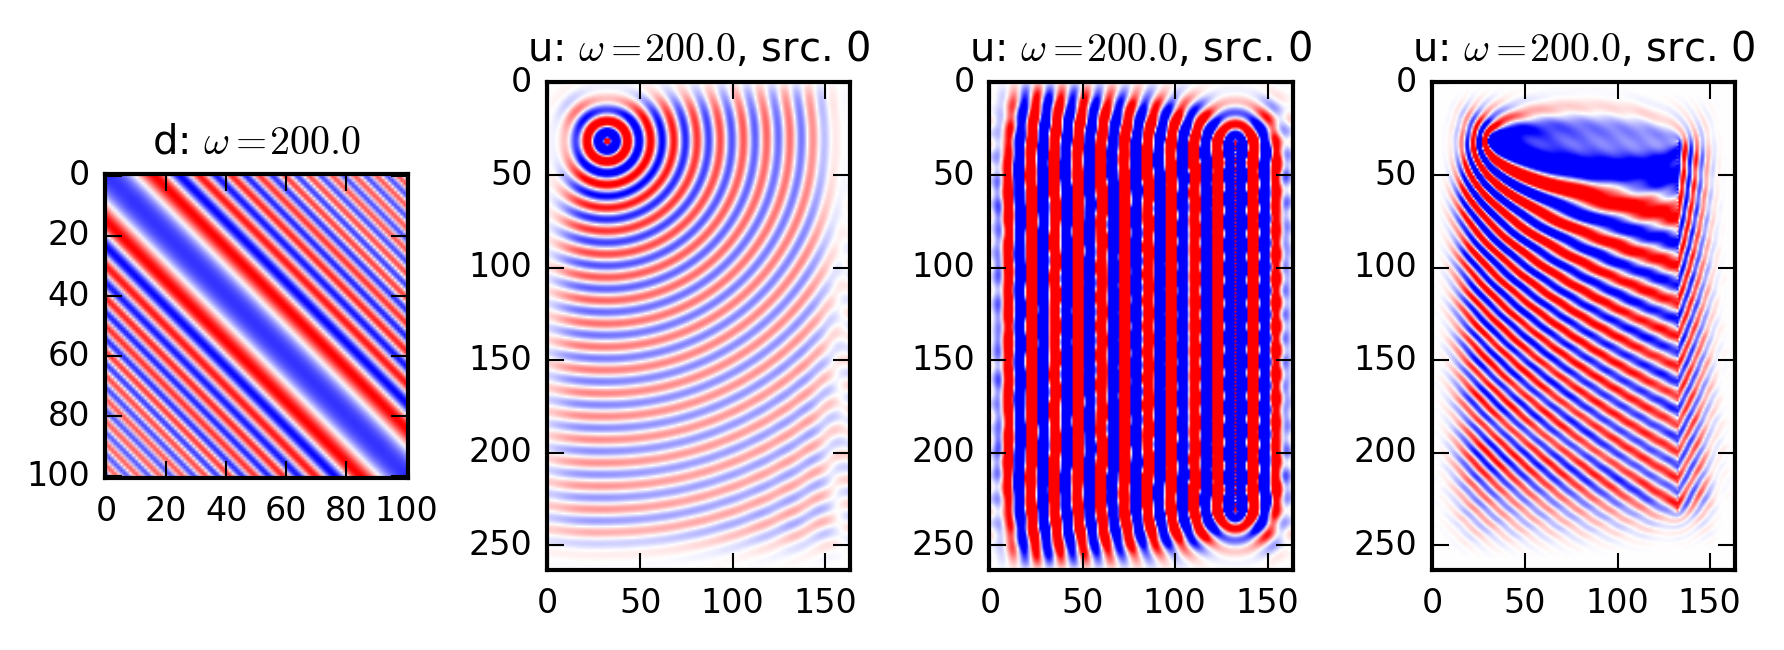

In [12]:
freqNum = 0
srcNum = 0

frt = uF[freqNum]
brt = uB[freqNum]
drt = d[freqNum]
grt = g[freqNum]
frt.shape = (nsrc, nz, nx)
brt.shape = (nsrc, nz, nx)
grt.shape = (nsrc, nz, nx)
clipScaleF = 1e-1 * abs(frt[srcNum]).max()
clipScaleB = 1e-1 * abs(brt[srcNum]).max()
clipScaleG = 1e-1 * abs(grt[srcNum]).max()

fig = plt.figure()

ax1 = fig.add_subplot(1,4,1)
plt.imshow(drt.real, cmap=cm.bwr)
plt.title('d: $\omega = %0.1f$'%(freqs[freqNum],))

ax2 = fig.add_subplot(1,4,2)
plt.imshow(frt[srcNum].real, vmin=-clipScaleF, vmax=clipScaleF, cmap=cm.bwr)
plt.title('u: $\omega = %0.1f$, src. %d'%(freqs[freqNum], srcNum))

ax3 = fig.add_subplot(1,4,3)
plt.imshow(brt[srcNum].real, vmin=-clipScaleB, vmax=clipScaleB, cmap=cm.bwr)
plt.title('u: $\omega = %0.1f$, src. %d'%(freqs[freqNum], srcNum))

ax4 = fig.add_subplot(1,4,4)
plt.imshow(grt[srcNum].real, vmin=-clipScaleG, vmax=clipScaleG, cmap=cm.bwr)
plt.title('u: $\omega = %0.1f$, src. %d'%(freqs[freqNum], srcNum))

fig.tight_layout()

In [12]:
sp._remote.reduceMul('forwardResultTracker', 'backpropResultTracker', 0)[0].shape

RemoteError: AttributeError('commonReducer' object has no attribute 'sum')